In [1]:
# standart libs
import sys
import random
import copy
import cProfile


# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt


# local
import functions.realization_setup as real_setup
import functions.realization_run as real_run
import functions.post_processing as post_pro
import functions.uq_runs as uq_runs

# executable
print(sys.executable)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/home/namur/coding/notebooks/env/bin/python3


# Create an artificial line

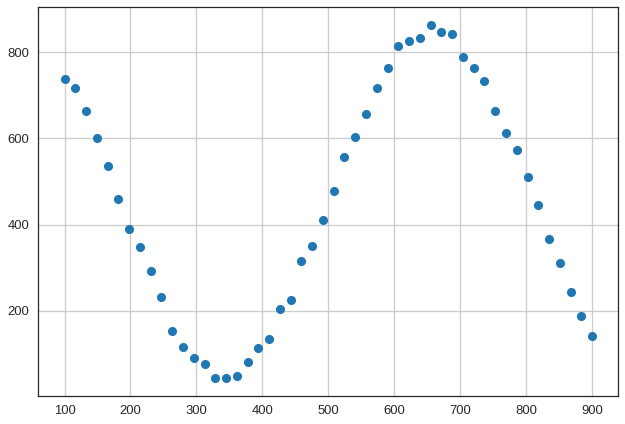

In [12]:
# sinus curve
xvals = np.linspace(-4, 4, 50)
yvals = np.sin(xvals)

# scale up and transform
xvals = xvals * 100 + 500
yvals = yvals * 400 + 450

# add noise
noise = np.random.normal(0,10,len(yvals))
yvals = yvals + noise

# plot
plt.plot(xvals, yvals, 'o')
plt.grid()

# Interpolate line with low nugget effect

In [13]:
# instantiate the geo_model
geo_model = gp.create_model("GeoModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[1, 1, 1]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


In [14]:
# meta
geo_model_extent = [0,1000,0,1000,0,1000]
section = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }

# create surface_points
df_sp = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface', 'smooth'])
df_sp['X'] = xvals
df_sp['Y'] = 500
df_sp['Z'] = yvals
df_sp['surface'] = 'rock1'
df_sp['smooth'] = 0.000001

# create orientation
df_or = pd.DataFrame(columns=['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation'])
df_or['X'] = xvals[np.where(yvals == np.max(yvals))]
df_or['Y'] = 500 + 1
df_or['Z'] = np.max(yvals)
df_or['formation'] = 'rock1'
df_or['dip'] = 0
df_or['azimuth'] = 90
df_or['polarity'] = 1

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()
Run realizations setup checks until stable workflow.


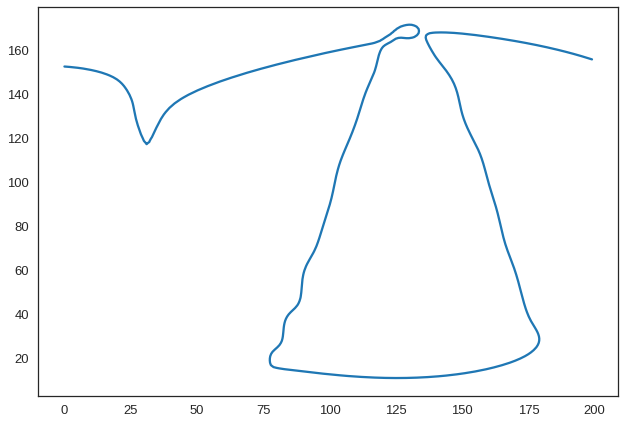

In [15]:
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent,
        section=section,
        series_df=series_df,
        surfaces_df=surfaces_df,
        surface_points_original_df=df_sp,
        orientations_original_df=df_or
)

if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    
contours = post_pro.compute_section_contours(geo_model)
interpolated_line = contours['rock1']
interpolated_line.shape
plt.plot(interpolated_line[:,0], interpolated_line[:,1])

# Interpolate line with height nugget effect

In [16]:
# meta
geo_model_extent = [0,1000,0,1000,0,1000]
section = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }

# create surface_points
df_sp = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface', 'smooth'])
df_sp['X'] = xvals
df_sp['Y'] = 500
df_sp['Z'] = yvals
df_sp['surface'] = 'rock1'
df_sp['smooth'] = 0.1

# create orientation
df_or = pd.DataFrame(columns=['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation'])
df_or['X'] = xvals[np.where(yvals == np.max(yvals))]
df_or['Y'] = 500 + 1
df_or['Z'] = np.max(yvals)
df_or['formation'] = 'rock1'
df_or['dip'] = 0
df_or['azimuth'] = 90
df_or['polarity'] = 1

Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


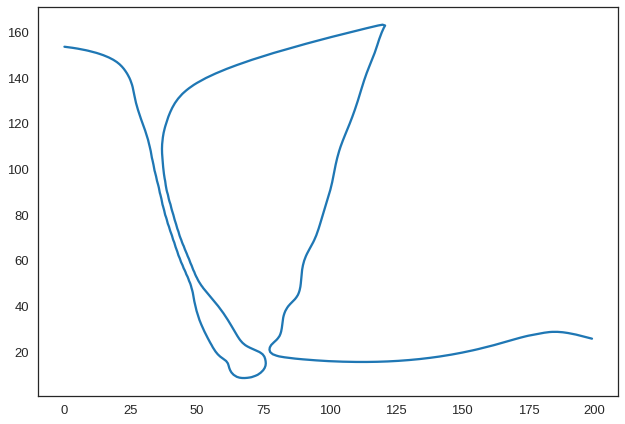

In [17]:
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent,
        section=section,
        series_df=series_df,
        surfaces_df=surfaces_df,
        surface_points_original_df=df_sp,
        orientations_original_df=df_or
)

geo_model.modify_surface_points(
    geo_model.surface_points.df.index, smooth=0.0001
)
geo_model.update_to_interpolator()


if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    
contours = post_pro.compute_section_contours(geo_model)
interpolated_line = contours['rock1']
interpolated_line.shape
plt.plot(interpolated_line[:,0], interpolated_line[:,1])